22/05/2025-28/05/2025 prediction

In [1]:
!pip install yfinance

In [2]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=10ec43bc5bca300d538824ceef0995020e6ff6cc455f1acffc42c9e1f067b202
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

📊 Evaluation Metrics for PLTR
RMSE: 3.9491
MAE: 2.8136
Direction Accuracy: 54.31%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

📈 Last Actual Close: $120.58
🔮 Predicted Next Close: $118.09
⚠️ Recommendation: SELL PLTR


<ipython-input-15-67c6f02f4d44>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


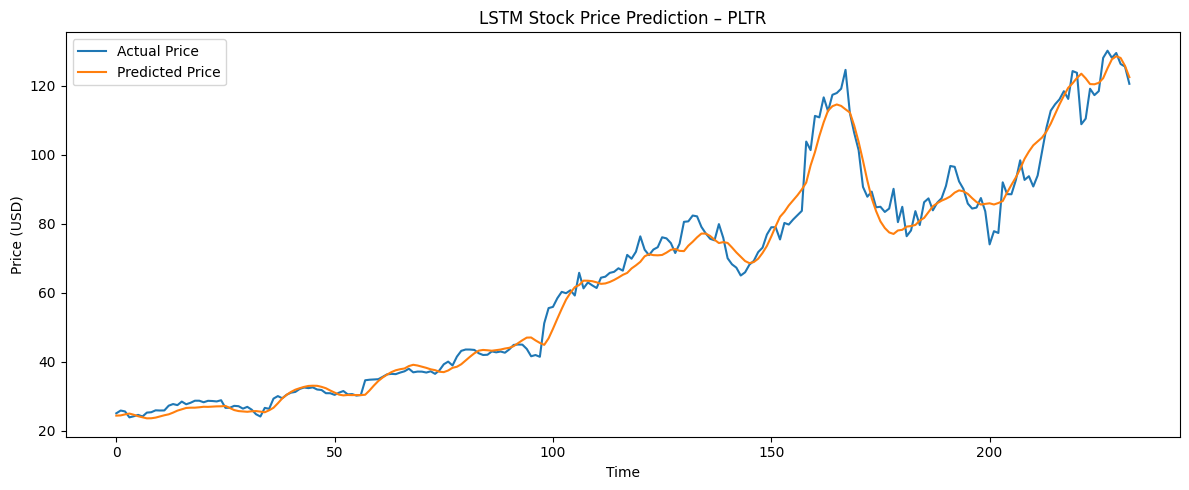

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

📆 5-Day Trading Forecast:


,Predicted_Close,Recommendation
Date,,
2025-05-22,118.09,SELL
2025-05-23,113.77,SELL
2025-05-26,109.76,SELL
2025-05-27,106.17,SELL
2025-05-28,103.04,SELL


In [15]:
#PLTR
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Stock Data ===
ticker = 'PLTR'
data = yf.download(ticker, start='2024-01-01', end='2025-05-22', interval='1d')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# === Step 3: Drop NA after indicators ===
data = data.dropna()

# === Step 4: Scale features ===
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 5: Create Sequences ===
lookback = 90
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# === Step 6: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=70, batch_size=32, verbose=0, callbacks=[es])

# === Step 7: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 8: Predict Next Day and Recommend Buy/Sell ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# === Step 9: Plot Prediction vs Actual ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Stock Price Prediction – {ticker}')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 10: Predict Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

# === Step 11: Format Trading Day Forecast ===
future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast:")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step

📊 Evaluation Metrics for UPST
RMSE: 5.8262
MAE: 4.5469
Direction Accuracy: 49.58%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

📈 Last Actual Close: $43.92
🔮 Predicted Next Close: $50.24
✅ Recommendation: BUY UPST


<ipython-input-17-dd544c60f006>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


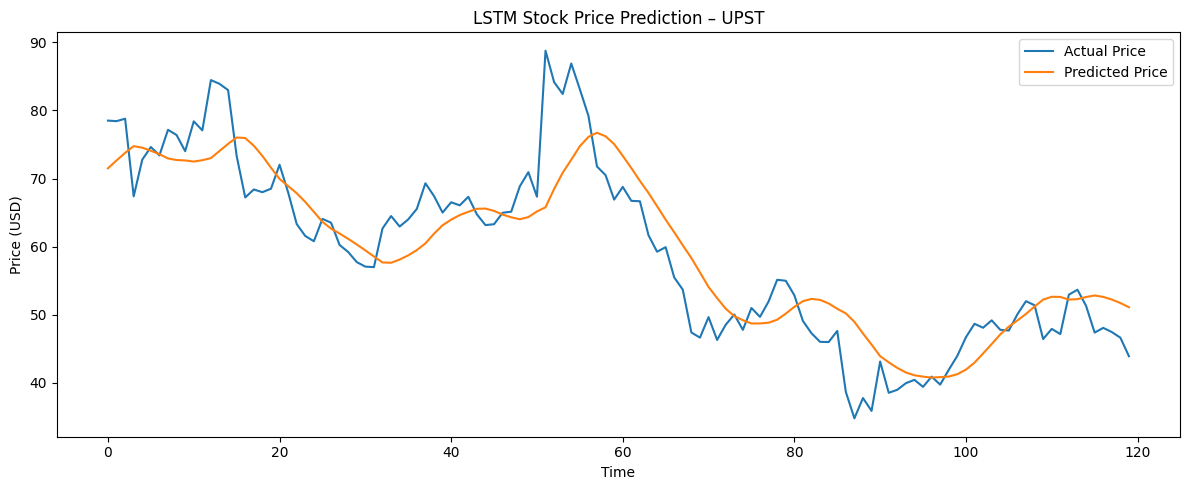

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

📆 5-Day Trading Forecast:


,Predicted_Close,Recommendation
Date,,
2025-05-22,50.24,BUY
2025-05-23,49.49,SELL
2025-05-26,48.86,SELL
2025-05-27,48.35,SELL
2025-05-28,47.96,SELL


In [17]:
# UPST
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Stock Data ===
ticker = 'UPST'
data = yf.download(ticker, start='2024-05-01', end='2025-05-22', interval='1d')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# === Step 3: Drop NA after indicators ===
data = data.dropna()

# === Step 4: Scale features ===
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 5: Create Sequences ===
lookback = 120
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# === Step 6: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=80, batch_size=32, verbose=0, callbacks=[es])

# === Step 7: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 8: Predict Next Day and Recommend Buy/Sell ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# === Step 9: Plot Prediction vs Actual ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Stock Price Prediction – {ticker}')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 10: Predict Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

# === Step 11: Format Trading Day Forecast ===
future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast:")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

📊 Evaluation Metrics for SOFI (Weekly Data)
RMSE: 0.7058
MAE: 0.5190
Direction Accuracy: 50.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

📈 Last Actual Close: $12.80
🔮 Predicted Next Close: $14.10
✅ Recommendation: BUY SOFI


<ipython-input-7-4315d4551727>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


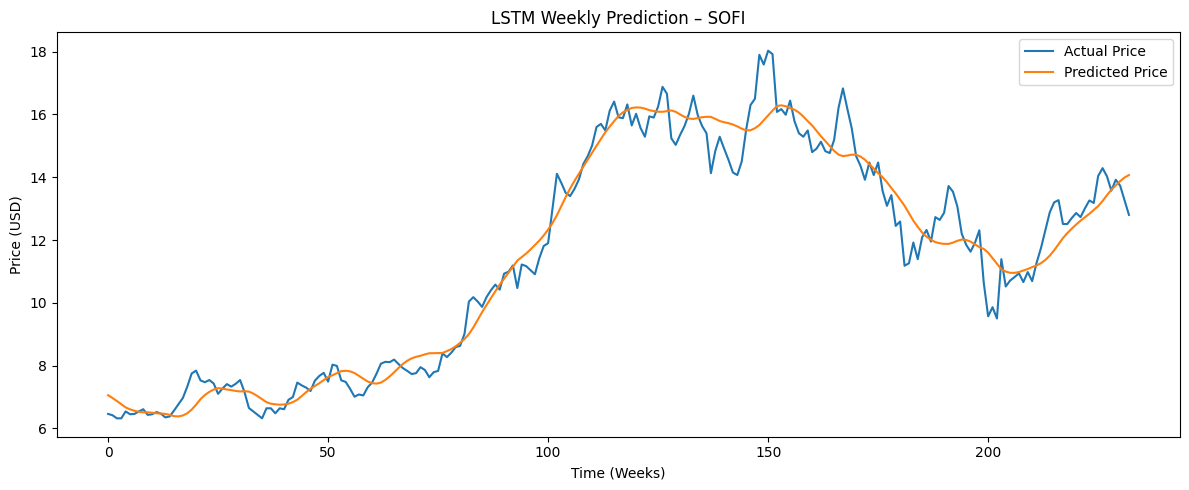

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

📆 5-Day Trading Forecast for SOFI:


,Predicted_Close,Recommendation
Date,,
2025-05-22,14.10,BUY
2025-05-23,14.13,BUY
2025-05-26,14.15,BUY
2025-05-27,14.19,BUY
2025-05-28,14.23,BUY


In [7]:
# SOFI
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Weekly Stock Data ===
ticker = 'SOFI'
data = yf.download(ticker, start='2024-01-01', end='2025-05-22', interval='1D')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()
data['MA_diff'] = data['EMA20'] - data['MA20']

# === Step 3: Drop NA and Scale Features ===
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume', 'MA_diff']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 4: Create Sequences ===
lookback = 90
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'
X = np.array(X)
y = np.array(y)

# === Step 5: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adamax', loss='huber')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=70, batch_size=32, verbose=0, callbacks=[es])

# === Step 6: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker} (Weekly Data)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 7: Predict Next Week and Recommend ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# === Step 8: Plot Actual vs Predicted ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 9: Forecast Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast for SOFI:")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

📊 Evaluation Metrics for AI (Weekly Data)
RMSE: 2.2416
MAE: 1.6679
Direction Accuracy: 49.28%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

📈 Last Actual Close: $21.87
🔮 Predicted Next Close: $25.28
✅ Recommendation: BUY AI


<ipython-input-23-7ff0e23b962f>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


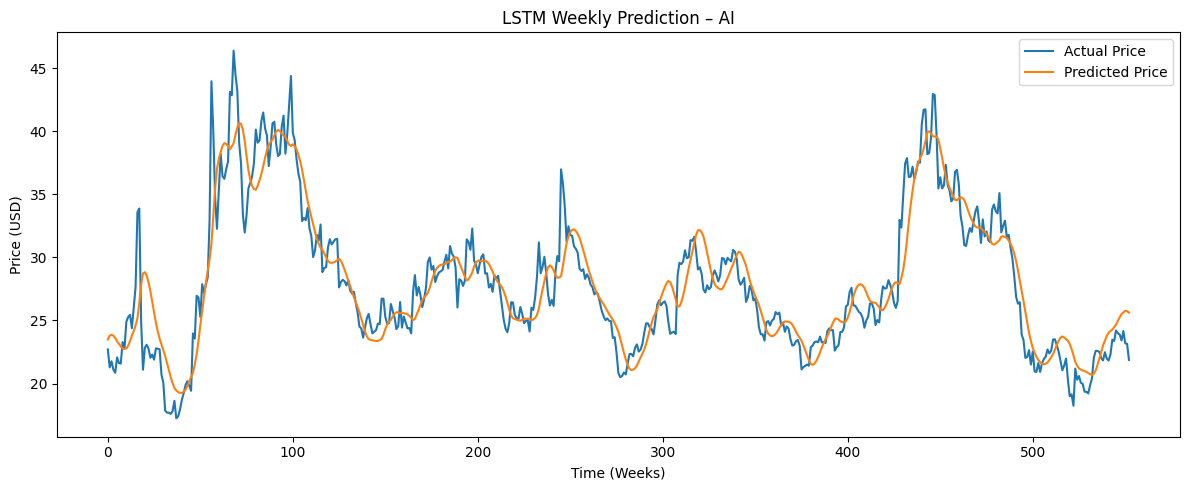

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

📆 5-Day Trading Forecast :


,Predicted_Close,Recommendation
Date,,
2025-05-22,25.28,BUY
2025-05-23,25.01,SELL
2025-05-26,24.77,SELL
2025-05-27,24.57,SELL
2025-05-28,24.39,SELL


In [23]:
# AI
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Weekly Stock Data ===
ticker = 'AI'
data = yf.download(ticker, start='2023-01-01', end='2025-05-22', interval='1D')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()
data['MA_diff'] = data['EMA20'] - data['MA20']

# === Step 3: Drop NA and Scale Features ===
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume', 'MA_diff']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 4: Create Sequences ===
lookback = 20
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'
X = np.array(X)
y = np.array(y)

# === Step 5: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adamax', loss='huber')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=32, verbose=0, callbacks=[es])

# === Step 6: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker} (Weekly Data)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 7: Predict Next Week and Recommend ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# === Step 8: Plot Actual vs Predicted ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 9: Forecast Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast :")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step

📊 Evaluation Metrics for TOL
RMSE: 10.1306
MAE: 8.6701
Direction Accuracy: 60.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


<ipython-input-18-39856b1ea727>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])



📈 Last Actual Close: $104.01
🔮 Predicted Next Close: $93.21
⚠️ Recommendation: SELL TOL


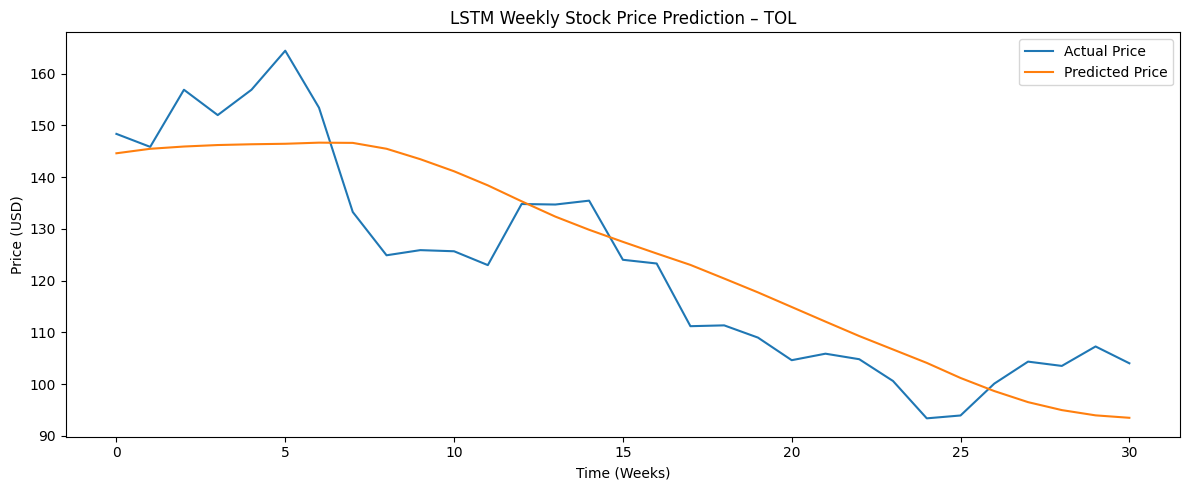

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

📆 Forecast for HRL


,Predicted_Close,Recommendation
Date,,
2025-05-28,93.2,SELL


In [18]:
# TOL

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'TOL'
data = yf.download(ticker, start='2023-05-01', end='2025-05-22', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 52
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=40, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Weeks
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-05-28'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(1)

#Show prediction
print("\n📆 Forecast for HRL")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step

📊 Evaluation Metrics for HRL
RMSE: 0.8905
MAE: 0.6961
Direction Accuracy: 61.11%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

📈 Last Actual Close: $29.42
🔮 Predicted Next Close: $29.64
✅ Recommendation: BUY HRL


<ipython-input-11-7ed011b71f68>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


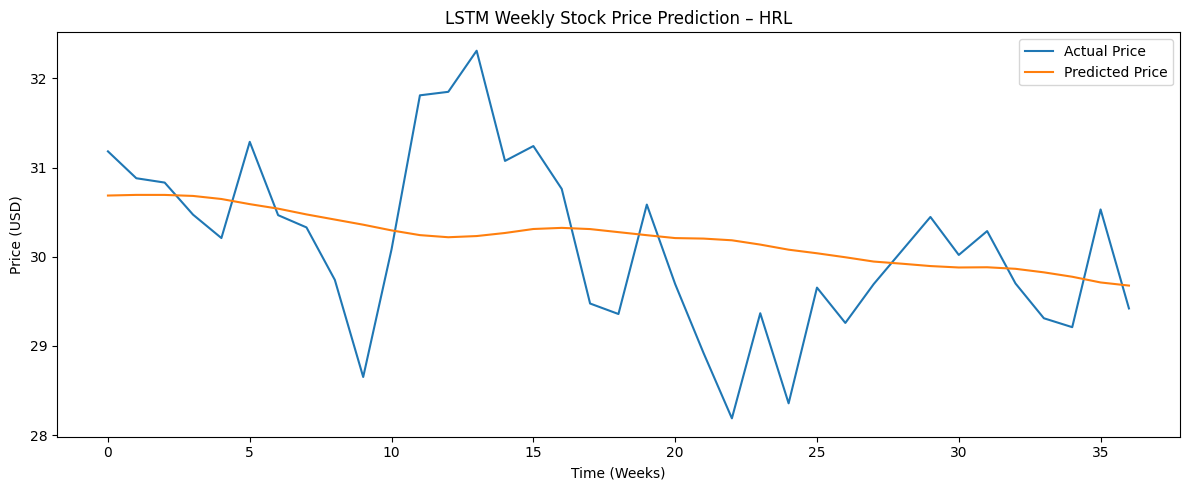

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

📆 Forecast for HRL


,Predicted_Close,Recommendation
Date,,
2025-05-28,29.6,BUY


In [11]:
# HRL
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'HRL'
data = yf.download(ticker, start='2023-05-01', end='2025-05-22', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20','Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 52
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=30, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Weeks
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-05-28'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(1)

#Show prediction
print("\n📆 Forecast for HRL")
display(forecast_df)



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step

📊 Evaluation Metrics for RHI
RMSE: 2.2223
MAE: 1.8377
Direction Accuracy: 54.55%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step

📈 Last Actual Close: $45.58
🔮 Predicted Next Close: $44.01
⚠️ Recommendation: SELL RHI


<ipython-input-14-8e1c68e1891f>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


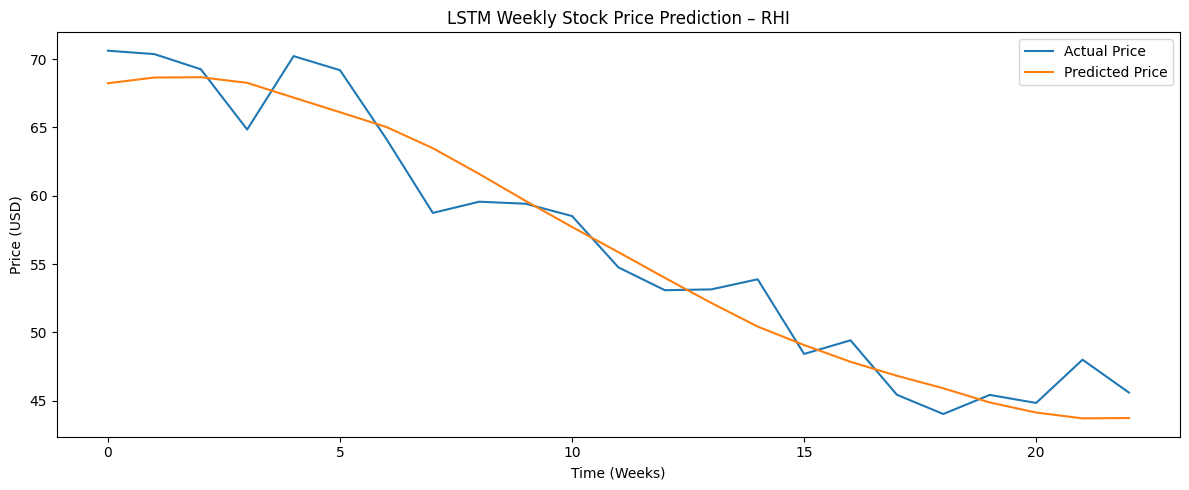

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

📆 Forecast for RHI


,Predicted_Close,Recommendation
Date,,
2025-05-28,44.01,SELL


In [14]:
# RHI

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'RHI'
data = yf.download(ticker, start='2023-05-01', end='2025-05-22', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=40, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Week
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-05-28'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

#Show prediction
print("\n📆 Forecast for RHI")
display(forecast_df)



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step

📊 Evaluation Metrics for DTE
RMSE: 5.8357
MAE: 4.4550
Direction Accuracy: 56.25%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

📈 Last Actual Close: $136.11
🔮 Predicted Next Close: $137.69
✅ Recommendation: BUY DTE


<ipython-input-15-e8dc2a0b6f81>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


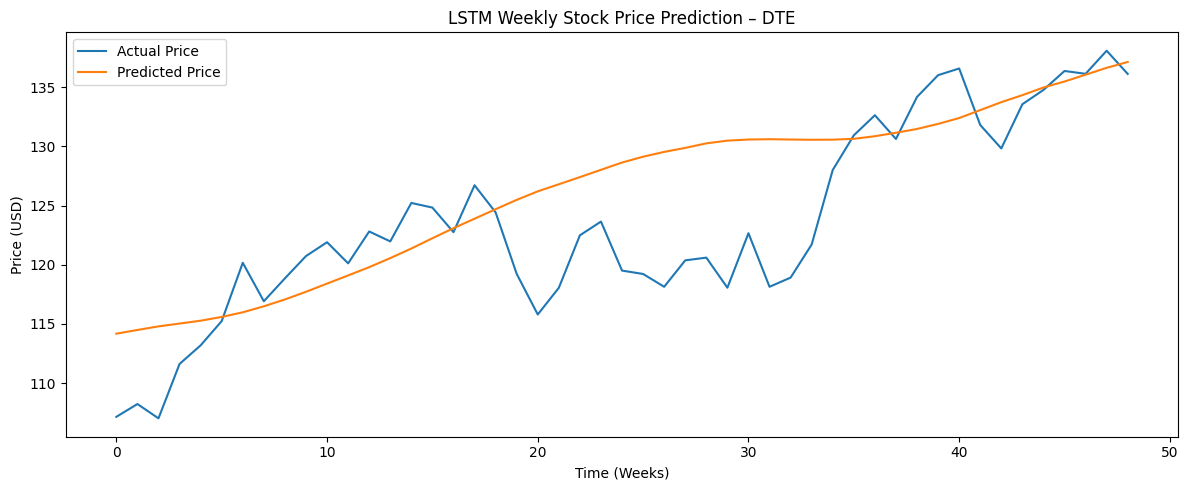

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

📆 Forecast for DTE


,Predicted_Close,Recommendation
Date,,
2025-05-28,137.69,BUY


In [15]:
# DTE

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'DTE'
data = yf.download(ticker, start='2023-05-01', end='2025-05-22', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20','Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 40
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=25, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")
if predicted_next_close > last_close:
    print(f"✅ Recommendation: BUY {ticker}")
else:
    print(f"⚠️ Recommendation: SELL {ticker}")

# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Week
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-05-28'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

#Show prediction
print("\n📆 Forecast for DTE")
display(forecast_df)



In [16]:
benchmark = yf.download('^GSPC', start='2025-05-15', end='2025-05-22', interval='1d')

start_price = benchmark['Close'].iloc[0].item()
end_price = benchmark['Close'].iloc[-1].item()

benchmark_return = (end_price - start_price) / start_price
print(f"Benchmark return (2025-05-15 to 2025-05-21): {benchmark_return:.2%}")



[*********************100%***********************]  1 of 1 completed

Benchmark return (2025-05-15 to 2025-05-21): -1.22%
